# **PT2 - ANÁLISIS DE LA RELACIÓN RENTABILIDAD-RIESGO Y MODELACIÓN**

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [14]:
# Leer archivo
df = pd.read_excel("datos_estudio_riesgovsrent.xlsx")
trad_df = pd.read_excel("fondo_tradicionales_riesgo.xlsx")
impact_df = pd.read_excel("fondo_impacto_riesgo.xlsx")

## **Exploración visual de la rentabilidad y el riesgo.**

In [3]:
# Filtrar columnas necesarias para graficar
df_plot = df[['tipo', 'IRR', 'riesgo']].dropna()

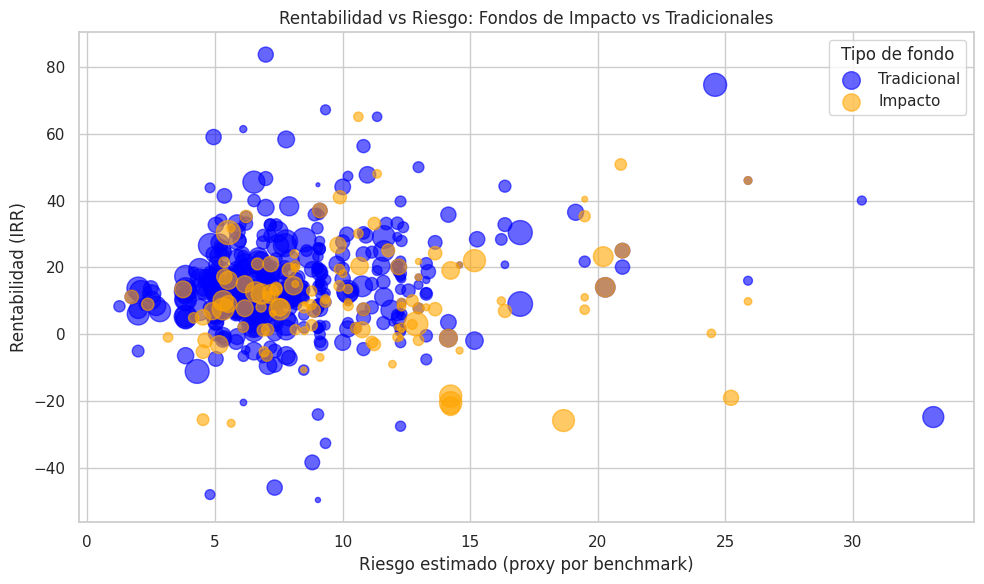

In [7]:
# Paleta de colores y estilo homogéneos
colores = {'tradicional': 'blue', 'impacto': 'orange'}
sns.set(style="whitegrid")

# Verificar si existe 'Fund Size' y crear tamaño si procede
if 'Fund Size' in df.columns:
    df_plot = df[['tipo', 'IRR', 'riesgo', 'Fund Size']].dropna().copy()
    df_plot['size'] = np.sqrt(df_plot['Fund Size']) * 5
else:
    df_plot = df[['ripo', 'IRR', 'riesgo']].dropna().copy()
    df_plot['size'] = 100  # tamaño fijo

# Figura
plt.figure(figsize=(10, 6))
plt.title("Rentabilidad vs Riesgo: Fondos de Impacto vs Tradicionales")

# Gráfico de dispersión
for fondo_tipo in ['tradicional', 'impacto']:
    tipo_df = df_plot[df_plot['tipo'] == fondo_tipo]
    if tipo_df.empty:
        continue

    plt.scatter(tipo_df['riesgo'], tipo_df['IRR'],
                s=tipo_df['size'],
                color=colores[fondo_tipo],
                alpha=0.6,
                label=fondo_tipo.capitalize())

plt.xlabel("Riesgo estimado (proxy por benchmark)")
plt.ylabel("Rentabilidad (IRR)")
plt.legend(title="Tipo de fondo")
plt.tight_layout()
plt.show()


## **Regresión Lineal Simple por Tipo de Fondo**

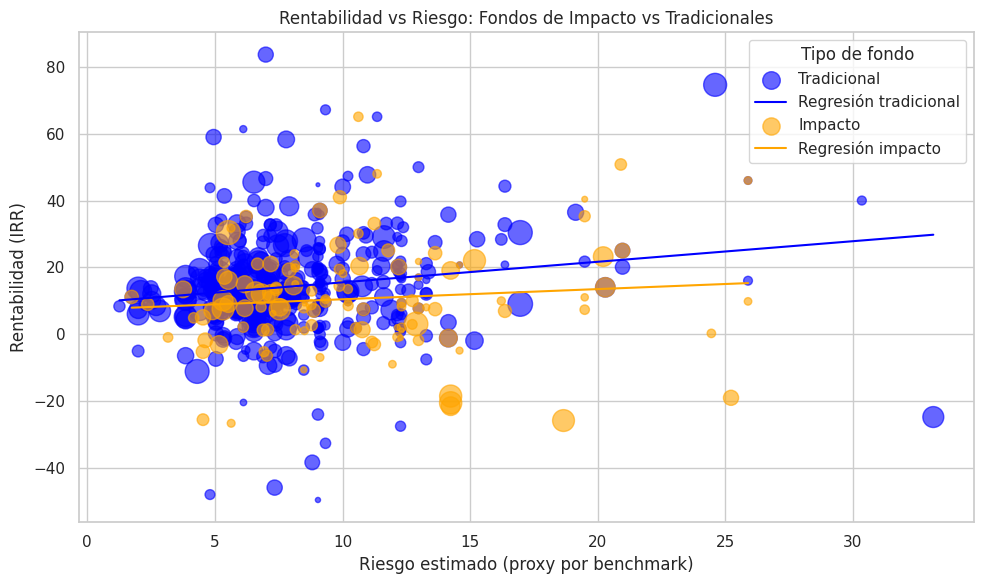

In [10]:
# Paleta de colores
colores = {'tradicional': 'blue', 'impacto': 'orange'}

# Estilo y figura
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title("Rentabilidad vs Riesgo: Fondos de Impacto vs Tradicionales")

# Si no tienes la columna 'size', puedes crearla
if 'Fund Size' in df_plot.columns:
    df_plot['size'] = np.sqrt(df_plot['Fund Size']) * 5
else:
    df_plot['size'] = 100

# Inicializar modelos fuera del bucle
modelo_trad = None
modelo_imp = None

# Dibujar dispersión y regresión para cada tipo de fondo
for fondo_tipo in ['tradicional', 'impacto']:
    tipo_df = df_plot[df_plot['tipo'] == fondo_tipo]
    if tipo_df.empty:
        continue

    # Gráfico de dispersión
    plt.scatter(tipo_df['riesgo'], tipo_df['IRR'],
                s=tipo_df['size'],
                alpha=0.6,
                color=colores[fondo_tipo],
                label=fondo_tipo.capitalize())

    # Ajustar y graficar regresión lineal
    X = sm.add_constant(tipo_df['riesgo'])
    y = tipo_df['IRR']
    modelo = sm.OLS(y, X).fit()

    # Guardar modelo correspondiente
    if fondo_tipo == 'tradicional':
        modelo_trad = modelo
    else:
        modelo_imp = modelo

    # Graficar la regresión
    x_vals = np.linspace(tipo_df['riesgo'].min(), tipo_df['riesgo'].max(), 100)
    X_vals = sm.add_constant(x_vals)
    y_vals = modelo.predict(X_vals)
    plt.plot(x_vals, y_vals, color=colores[fondo_tipo], label=f"Regresión {fondo_tipo}")

# Etiquetas
plt.xlabel("Riesgo estimado (proxy por benchmark)")
plt.ylabel("Rentabilidad (IRR)")
plt.legend(title="Tipo de fondo")
plt.tight_layout()
plt.show()



=== Regresión para Fondos Tradicionales ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     11.12
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           0.000926
Time:                        22:29:43   Log-Likelihood:                -1784.9
No. Observations:                 435   AIC:                             3574.
Df Residuals:                     433   BIC:                             3582.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

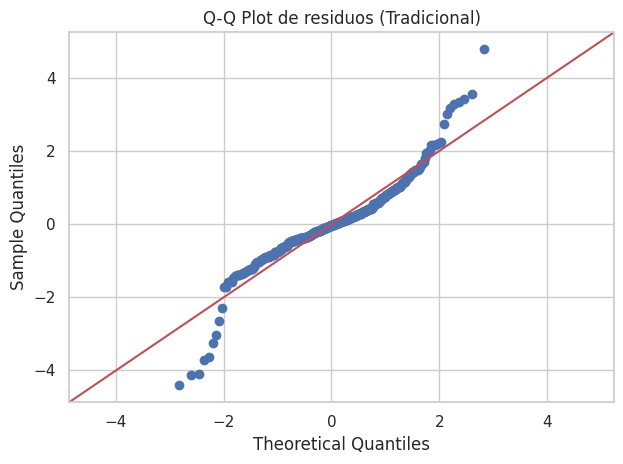

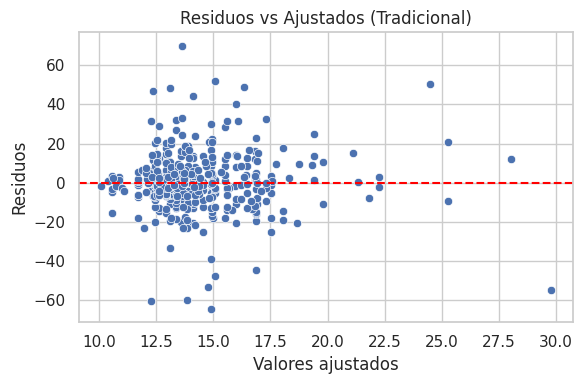

VIF Tradicional:
  Variable       VIF
0    const  5.503787
1   riesgo  1.000000


In [17]:
print("=== Regresión para Fondos Tradicionales ===")
print(modelo_trad.summary())

# Residuos
resid_trad = modelo_trad.resid
fitted_trad = modelo_trad.fittedvalues

# Q-Q Plot (normalidad)
sm.qqplot(resid_trad, line='45', fit=True)
plt.title('Q-Q Plot de residuos (Tradicional)')
plt.tight_layout()
plt.show()

# Homocedasticidad
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_trad, y=resid_trad)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Ajustados (Tradicional)')
plt.tight_layout()
plt.show()

# VIF (aunque con una sola variable explicativa no es relevante, se deja como estructura)
X_trad_vif = sm.add_constant(trad_df[['riesgo']].dropna())
vif_trad = pd.DataFrame()
vif_trad["Variable"] = X_trad_vif.columns
vif_trad["VIF"] = [variance_inflation_factor(X_trad_vif.values, i) for i in range(X_trad_vif.shape[1])]
print("VIF Tradicional:")
print(vif_trad)

=== Regresión para Fondos de Impacto ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.188
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.278
Time:                        22:29:54   Log-Likelihood:                -497.27
No. Observations:                 120   AIC:                             998.5
Df Residuals:                     118   BIC:                             1004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

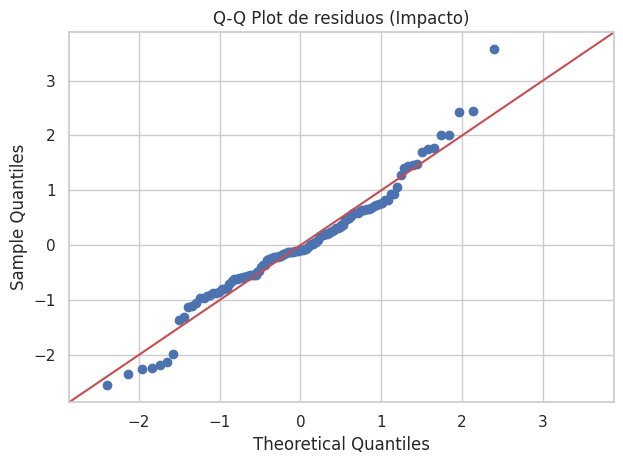

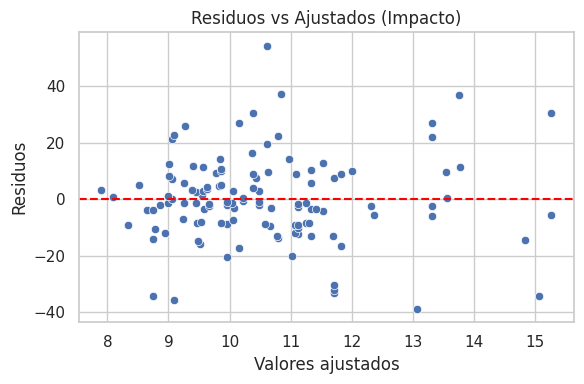

VIF Impacto:
  Variable       VIF
0    const  5.403366
1   riesgo  1.000000


In [18]:
print("=== Regresión para Fondos de Impacto ===")
print(modelo_imp.summary())

resid_imp = modelo_imp.resid
fitted_imp = modelo_imp.fittedvalues

sm.qqplot(resid_imp, line='45', fit=True)
plt.title('Q-Q Plot de residuos (Impacto)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_imp, y=resid_imp)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Ajustados (Impacto)')
plt.tight_layout()
plt.show()

X_imp_vif = sm.add_constant(impact_df[['riesgo']].dropna())
vif_imp = pd.DataFrame()
vif_imp["Variable"] = X_imp_vif.columns
vif_imp["VIF"] = [variance_inflation_factor(X_imp_vif.values, i) for i in range(X_imp_vif.shape[1])]
print("VIF Impacto:")
print(vif_imp)

## **Modelo de Regresión Lineal Múltiple**

In [21]:
# Asegúrate de que no haya valores faltantes
reg_df = df[['IRR', 'riesgo', 'tipo', 'Vintage', 'Fund Size']].dropna().copy()

# Codificar 'type' como dummy: 0 = tradicional, 1 = impacto
reg_df['tipo'] = reg_df['tipo'].map({'tradicional': 0, 'impacto': 1})

# Transformar el tamaño del fondo con logaritmo
reg_df['log_fund_size'] = np.log(reg_df['Fund Size'])

# Modelo de regresión lineal
modelo = smf.ols(
    formula="IRR ~ riesgo + tipo + C(Vintage) + log_fund_size",
    data=reg_df
).fit()

# Resultados
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     3.655
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           7.14e-09
Time:                        22:31:26   Log-Likelihood:                -2245.4
No. Observations:                 555   AIC:                             4545.
Df Residuals:                     528   BIC:                             4661.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.5953      5

## **Análisis por grupos de vintage year**


=== REGRESIÓN PARA 2001-2005 | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.781
Date:                Mon, 23 Jun 2025   Prob (F-statistic):             0.0978
Time:                        22:32:20   Log-Likelihood:                -545.77
No. Observations:                 133   AIC:                             1096.
Df Residuals:                     131   BIC:                             1101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


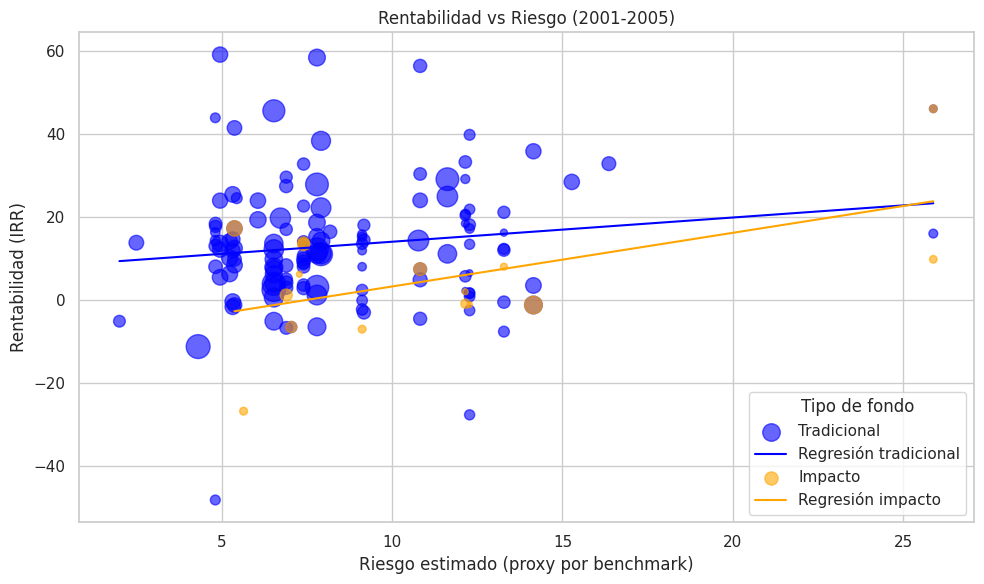


=== REGRESIÓN PARA 2006-2010 | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7027
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.403
Time:                        22:32:21   Log-Likelihood:                -765.35
No. Observations:                 190   AIC:                             1535.
Df Residuals:                     188   BIC:                             1541.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

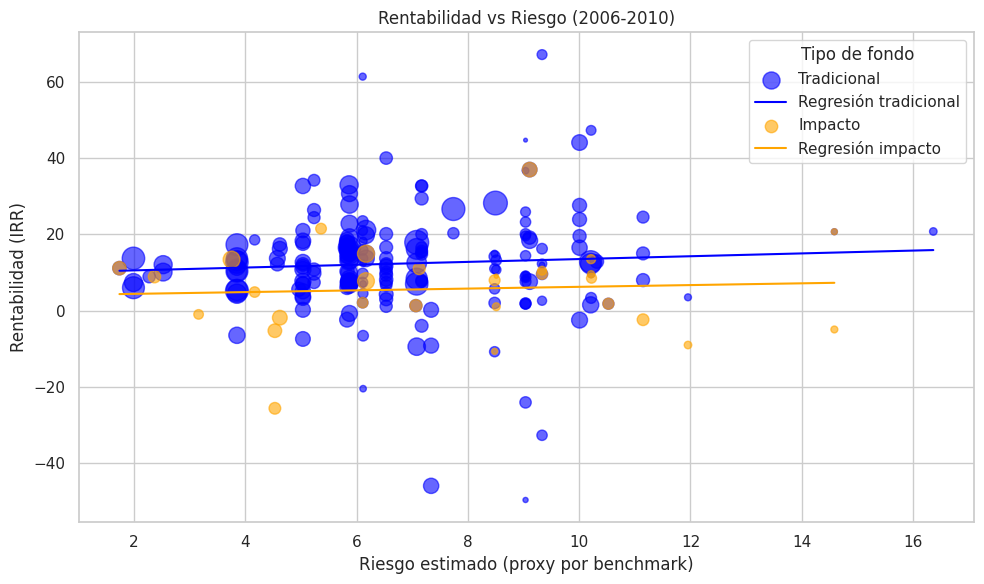


=== REGRESIÓN PARA 2011-2015 | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.589
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.115
Time:                        22:32:21   Log-Likelihood:                -179.37
No. Observations:                  45   AIC:                             362.7
Df Residuals:                      43   BIC:                             366.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

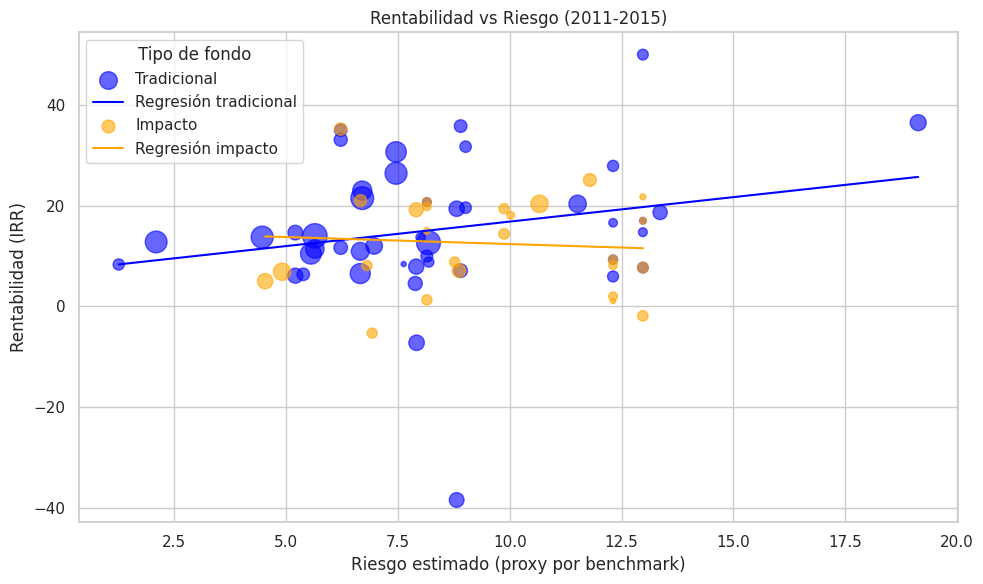


=== REGRESIÓN PARA 2016-2020 | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.827
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.182
Time:                        22:32:21   Log-Likelihood:                -215.54
No. Observations:                  53   AIC:                             435.1
Df Residuals:                      51   BIC:                             439.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

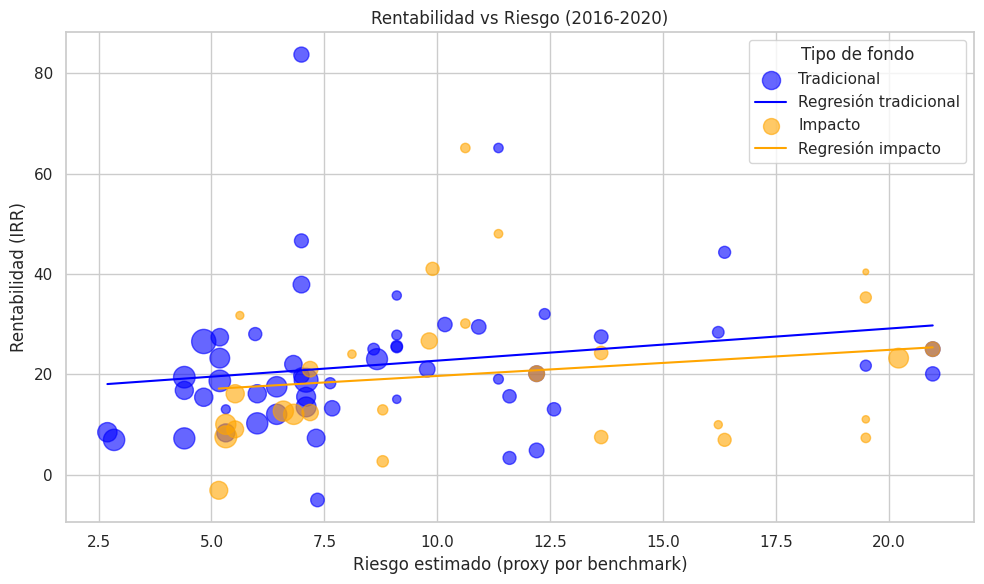


=== REGRESIÓN PARA 2021-2025 | TRADICIONAL ===
                            OLS Regression Results                            
Dep. Variable:                    IRR   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                   0.07283
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.792
Time:                        22:32:22   Log-Likelihood:                -64.220
No. Observations:                  14   AIC:                             132.4
Df Residuals:                      12   BIC:                             133.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


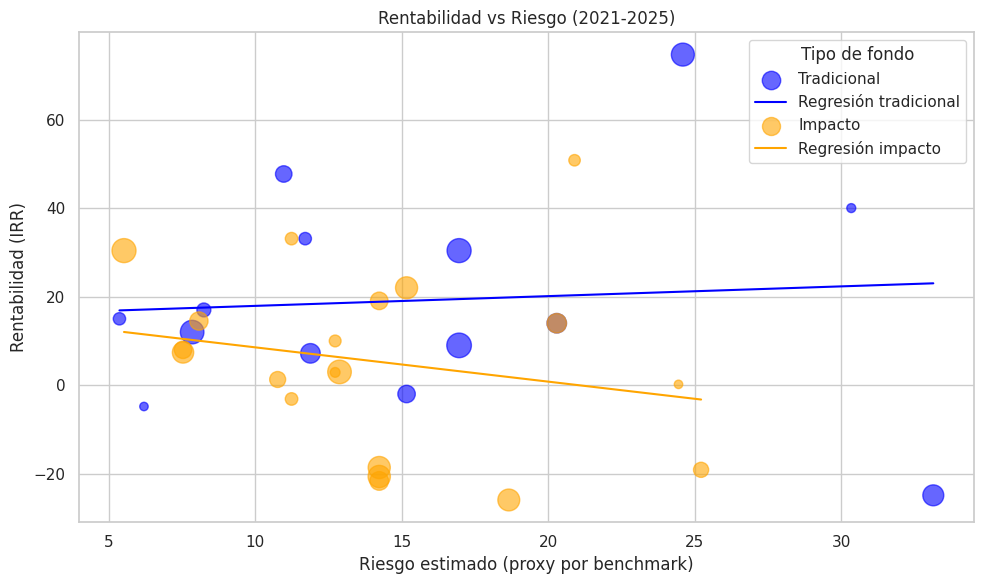

In [22]:
# Crear grupos de 5 años
def group_vintage_year(year):
    if pd.isna(year):
        return 'Unknown'
    elif year <= 2005:
        return '2001-2005'
    elif year <= 2010:
        return '2006-2010'
    elif year <= 2015:
        return '2011-2015'
    elif year <= 2020:
        return '2016-2020'
    elif year <= 2025:
        return '2021-2025'
    else:
        return 'Post-2025'

df['grupo_año'] = df['Vintage'].apply(group_vintage_year)

# Preparar dataset para graficar
df_plot = df[['tipo', 'IRR', 'riesgo', 'grupo_año', 'Fund Size']].dropna().copy()
df_plot['size'] = np.sqrt(df_plot['Fund Size']) * 5  # tamaño visual proporcional

# Definir orden de grupos
groups = ['2001-2005', '2006-2010', '2011-2015', '2016-2020', '2021-2025']

# Iterar por grupo y tipo y generar gráficos + resumen
for group in groups:
    subset = df_plot[df_plot['grupo_año'] == group]
    if subset.empty:
        continue

    plt.figure(figsize=(10, 6))
    plt.title(f"Rentabilidad vs Riesgo ({group})")

    colores = {'tradicional': 'blue', 'impacto': 'orange'}

    for fondo_tipo in ['tradicional', 'impacto']:
        tipo_df = subset[subset['tipo'] == fondo_tipo]
        if tipo_df.empty:
            continue

        # Gráfico de dispersión
        plt.scatter(tipo_df['riesgo'], tipo_df['IRR'],
                    s=tipo_df['size'],
                    color=colores[fondo_tipo],
                    alpha=0.6,
                    label=fondo_tipo.capitalize())

        # Ajuste de regresión con statsmodels
        X = sm.add_constant(tipo_df['riesgo'])
        y = tipo_df['IRR']
        modelo = sm.OLS(y, X).fit()

        # Línea de regresión
        x_vals = np.linspace(tipo_df['riesgo'].min(), tipo_df['riesgo'].max(), 100)
        X_vals = sm.add_constant(x_vals)
        y_vals = modelo.predict(X_vals)
        plt.plot(x_vals, y_vals, color=colores[fondo_tipo], label=f"Regresión {fondo_tipo}")

        # Mostrar resumen debajo
        print(f"\n=== REGRESIÓN PARA {group} | {fondo_tipo.upper()} ===")
        print(modelo.summary())

    plt.xlabel("Riesgo estimado (proxy por benchmark)")
    plt.ylabel("Rentabilidad (IRR)")
    plt.legend(title="Tipo de fondo")
    plt.tight_layout()
    plt.show()
